In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

print("Num GPU Available: ", len(tf.config.list_physical_devices('GPU')))
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Num GPU Available:  2


2022-05-04 21:42:39.217514: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:62:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:63:00.0, compute capability: 7.5



2022-05-04 21:42:41.792354: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9644 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:62:00.0, compute capability: 7.5
2022-05-04 21:42:41.797600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9644 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:63:00.0, compute capability: 7.5


# Evalulation Functions and True Labels

## Function to aggregate windowed predictions

In [3]:
def get_max_preds(preds, window_size=15):
    '''
    Aggregates every window_size predictions by summing probabilites of each
    Returns the class/index with the highest summed prediction
    '''
    final_preds = []
    for i in range(len(preds)//window_size):
        aggregated_preds = []
        for j in range(window_size):
            idx = i*window_size+j                                 # get indices for windows within whole record
            aggregated_preds.append(preds[idx])                   # append windows to list
        summed_preds = np.sum(np.array(aggregated_preds), axis=0) # sum aggregated predicions
        final_preds.append(np.argmax(summed_preds))               # get index of highest prediction and append to list
    return final_preds

## Read true labels for predictions

In [32]:
path = '/project/GutIntelligenceLab/bwl3xy/ecg'
os.chdir(path)

In [33]:
# Get true labels
database = pd.read_pickle('data/database.pkl')
Y = np.array(database['subclass'])
test_fold = [10] 
test_idx = np.where(np.isin(database['strat_fold'], test_fold))
y_true  = list(Y[test_idx])

In [35]:
label_map = {'NORM': 0, 'MI': 1, 'STTC': 2, 'HYP': 3, 'CD': 4}
label_list = list(label_map.keys())

# Read in data from TFRecords

In [7]:
path = '/project/GutIntelligenceLab/bwl3xy/ecg'
os.chdir(path)

In [8]:
def parse_ecg_tensor_from_TFR(TFRecord):
    dataset = (tf.data.TFRecordDataset(TFRecord).map(lambda x: tf.io.parse_tensor(x, tf.double)))
    dataset = dataset.map(lambda x: tf.reshape(x, [12,250]))
    return dataset

def parse_label_from_TFR(TFRecord):
    dataset = (tf.data.TFRecordDataset(TFRecord).map(lambda x: tf.io.parse_tensor(x, tf.int64)))
    dataset = dataset.map(lambda x: tf.reshape(x, []))
    return dataset

In [9]:
X_train_ds = parse_ecg_tensor_from_TFR('data/X_train.tfrecord')
X_val_ds = parse_ecg_tensor_from_TFR('data/X_val.tfrecord')
X_test_ds = parse_ecg_tensor_from_TFR('data/X_test.tfrecord')
Y_train_ds = parse_label_from_TFR('data/Y_train.tfrecord')
Y_val_ds = parse_label_from_TFR('data/Y_val.tfrecord')
Y_test_ds = parse_label_from_TFR('data/Y_test.tfrecord')

2022-05-04 21:42:48.607031: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9644 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:62:00.0, compute capability: 7.5
2022-05-04 21:42:48.608530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9644 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:63:00.0, compute capability: 7.5


In [10]:
BATCH_SIZE = 256

train_ds = tf.data.Dataset.zip((X_train_ds, Y_train_ds)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.zip((X_val_ds, Y_val_ds)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.zip((X_test_ds, Y_test_ds)).batch(1)

In [15]:
num_classes = 5
input_shape = (12,250)

# Model 1: 1D Basic CNN

In [16]:
model = keras.models.Sequential([
    
    keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", input_shape=input_shape),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),

    keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),

    keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),

    keras.layers.GlobalAveragePooling1D(),

    keras.layers.Dense(num_classes, activation="softmax")
])

model.build(input_shape)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 12, 64)            48064     
                                                                 
 batch_normalization_3 (Batc  (None, 12, 64)           256       
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 12, 64)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 12, 64)            12352     
                                                                 
 batch_normalization_4 (Batc  (None, 12, 64)           256       
 hNormalization)                                                 
                                                                 
 re_lu_4 (ReLU)              (None, 12, 64)           

In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
epochs = 30
model_output = 'models/basic_cnn.h5'

callbacks = [keras.callbacks.ModelCheckpoint(model_output, save_best_only=True, monitor="val_loss"),
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),]

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/30
868/868 [==============================] - 13s 14ms/step - loss: 1.2182 - accuracy: 0.5195 - val_loss: 1.1591 - val_accuracy: 0.5509 - lr: 0.0010
Epoch 2/30
868/868 [==============================] - 12s 14ms/step - loss: 1.0815 - accuracy: 0.5847 - val_loss: 1.0960 - val_accuracy: 0.5773 - lr: 0.0010
Epoch 3/30
868/868 [==============================] - 12s 14ms/step - loss: 1.0290 - accuracy: 0.6084 - val_loss: 1.0547 - val_accuracy: 0.5933 - lr: 0.0010
Epoch 4/30
868/868 [==============================] - 12s 14ms/step - loss: 0.9938 - accuracy: 0.6230 - val_loss: 1.0293 - val_accuracy: 0.6028 - lr: 0.0010
Epoch 5/30
868/868 [==============================] - 12s 14ms/step - loss: 0.9684 - accuracy: 0.6336 - val_loss: 1.0179 - val_accuracy: 0.6081 - lr: 0.0010
Epoch 6/30
868/868 [==============================] - 12s 14ms/step - loss: 0.9480 - accuracy: 0.6427 - val_loss: 1.0082 - val_accuracy: 0.6152 - lr: 0.0010
Epoch 7/30
868/868 [==============================] - 12s 

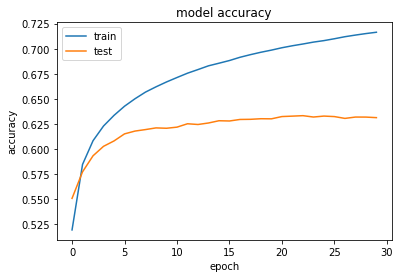

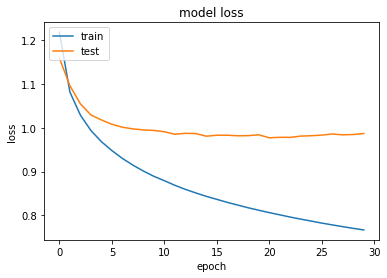

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
# model = tf.keras.models.load_model('models/basic_cnn.h5')
model.evaluate(test_ds)

32070/32070 [==============================] - 50s 2ms/step - loss: 1.0166 - accuracy: 0.6236


[1.0165705680847168, 0.6236357688903809]

In [21]:
preds = model.predict(test_ds)

In [27]:
len(y_pred)

2138

In [31]:
np.unique(y_true)

array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype='<U4')

In [36]:
# Get aggregated predictions
y_pred = get_max_preds(preds)
accuracy_score(y_true, y_pred)

0.6730589335827877

In [37]:
print(classification_report(y_true, y_pred, digits=3, target_names=label_list, zero_division=0))

              precision    recall  f1-score   support

        NORM      0.753     0.912     0.825       921
          MI      0.525     0.589     0.555       406
        STTC      0.624     0.587     0.605       351
         HYP      0.458     0.396     0.425       111
          CD      0.780     0.315     0.449       349

    accuracy                          0.673      2138
   macro avg      0.628     0.560     0.572      2138
weighted avg      0.678     0.673     0.655      2138



# Model 2: 1D Resnet
adapted from: https://github.com/hfawaz/dl-4-tsc/blob/master/classifiers/resnet.py

when tuning start with learning rate->mini_batch_size -> momentum-> #hidden_units -> # learning_rate_decay -> #layers 

In [38]:
def resnet1d(input_shape, nb_classes, dropout_rate=0.25, learning_rate=0.0001):
    
    n_feature_maps = 64

    input_layer = keras.layers.Input(input_shape)

    # BLOCK 1
    conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)
    
    output_block_1 = tf.keras.layers.Dropout(rate=dropout_rate)(output_block_1)

    
    # BLOCK 2
    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)
    
    output_block_2 = tf.keras.layers.Dropout(rate=dropout_rate)(output_block_2)

    
    # BLOCK 3
    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)
    
    output_block_3 = tf.keras.layers.Dropout(rate=dropout_rate)(output_block_3)

    
    # FINAL
    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)
    
    # insert droupout layer

    output_layer = tf.keras.layers.Dropout(rate=dropout_rate)(gap_layer)
    output_layer = keras.layers.Dense(nb_classes, activation='softmax')(output_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],
                  optimizer=opt)


    return model

In [39]:
learning_rate = 0.001
dropout_rate = 0.25

resnet_model = resnet1d(input_shape = input_shape,
                         nb_classes = num_classes,
                         learning_rate=learning_rate)

resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 250)]    0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 12, 64)       128064      ['input_1[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 12, 64)      256         ['conv1d_6[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation (Activation)        (None, 12, 64)       0           ['batch_normalization_6[0][0]

In [40]:
epochs = 50
model_output = 'models/resnet.h5'

callbacks = [keras.callbacks.ModelCheckpoint(model_output, save_best_only=True, monitor="val_loss"),
#              keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),]

history = resnet_model.fit(train_ds,
                           validation_data=val_ds,
                           epochs=epochs,
                           callbacks=callbacks,
                           verbose=1)

Epoch 1/50
868/868 [==============================] - 22s 23ms/step - loss: 1.2479 - accuracy: 0.5145 - val_loss: 1.1178 - val_accuracy: 0.5572
Epoch 2/50
868/868 [==============================] - 19s 22ms/step - loss: 1.0604 - accuracy: 0.5933 - val_loss: 1.0101 - val_accuracy: 0.6043
Epoch 3/50
868/868 [==============================] - 19s 22ms/step - loss: 0.9926 - accuracy: 0.6231 - val_loss: 0.9852 - val_accuracy: 0.6160
Epoch 4/50
868/868 [==============================] - 19s 22ms/step - loss: 0.9467 - accuracy: 0.6438 - val_loss: 0.9787 - val_accuracy: 0.6170
Epoch 5/50
868/868 [==============================] - 19s 22ms/step - loss: 0.9089 - accuracy: 0.6593 - val_loss: 0.9614 - val_accuracy: 0.6271
Epoch 6/50
868/868 [==============================] - 19s 22ms/step - loss: 0.8777 - accuracy: 0.6714 - val_loss: 0.9576 - val_accuracy: 0.6293
Epoch 7/50
868/868 [==============================] - 19s 22ms/step - loss: 0.8498 - accuracy: 0.6845 - val_loss: 0.9488 - val_accuracy:

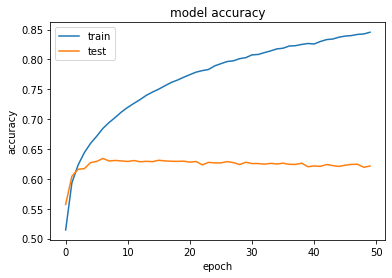

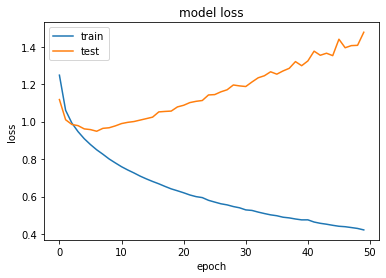

In [41]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
# resnet_model = tf.keras.models.load_model('models/resnet.h5')
resnet_model.evaluate(test_ds)

32070/32070 [==============================] - 94s 3ms/step - loss: 1.5714 - accuracy: 0.6075


[1.5713521242141724, 0.6075459718704224]

In [43]:
preds = resnet_model.predict(test_ds)

In [44]:
# Get aggregated predictions
y_pred = get_max_preds(preds)
accuracy_score(y_true, y_pred)

0.6810102899906455

In [45]:
print(classification_report(y_true, y_pred, digits=3, target_names=label_list, zero_division=0))

              precision    recall  f1-score   support

        NORM      0.738     0.944     0.828       921
          MI      0.552     0.507     0.529       406
        STTC      0.668     0.516     0.582       351
         HYP      0.454     0.396     0.423       111
          CD      0.712     0.447     0.549       349

    accuracy                          0.681      2138
   macro avg      0.625     0.562     0.582      2138
weighted avg      0.672     0.681     0.664      2138



# Model 3: 1D Inception

In [36]:
def inception1d(input_shape, nb_classes):

    input_layer = keras.layers.Input(input_shape)

    tower_1 = keras.layers.Conv1D(64, 1, padding='same', activation='relu')(input_layer)

    tower_2 = keras.layers.Conv1D(64, 1, padding='same', activation='relu')(input_layer)
    tower_2 = keras.layers.Conv1D(128, 3, padding='same', activation='relu')(tower_2)

    tower_3 = keras.layers.Conv1D(64, 1, padding='same', activation='relu')(input_layer)
    tower_3 = keras.layers.Conv1D(32, 5, padding='same', activation='relu')(tower_3)

    pool = keras.layers.MaxPooling1D(3, strides=1, padding='same')(input_layer)
    pool = keras.layers.Conv1D(32, 1, padding='same', activation='relu')(pool)


    output = keras.layers.concatenate([tower_1, tower_2, tower_3, pool], axis = -1)

    output = keras.layers.Flatten()(output)
    out = keras.layers.Dense(nb_classes, activation='softmax')(output)

    model = keras.models.Model(inputs = input_layer, outputs = out)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [37]:
inception_model = inception1d(input_shape = input_shape, 
                              nb_classes = num_classes)
inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 250)]    0           []                               
                                                                                                  
 conv1d_10 (Conv1D)             (None, 12, 64)       16064       ['input_1[0][0]']                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 12, 64)       16064       ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 12, 250)      0           ['input_1[0][0]']                
                                                                                              

In [48]:
def inception1d(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    conv1 = keras.layers.Conv1D(f1, 1, padding='same')(layer_in)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation('relu')(conv1)

    conv3 = keras.layers.Conv1D(f2_in, 1, padding='same', activation='relu')(layer_in)
    conv3 = keras.layers.Conv1D(f2_out, 3, padding='same')(conv3)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)

    conv5 = keras.layers.Conv1D(f3_in, 1, padding='same', activation='relu')(layer_in)
    conv5 = keras.layers.Conv1D(f3_out, 5, padding='same')(conv5)
    conv3 = keras.layers.BatchNormalization()(conv5)
    conv3 = keras.layers.Activation('relu')(conv5)

    pool = keras.layers.MaxPooling1D(3, strides=1, padding='same')(layer_in)
    pool = keras.layers.Conv1D(f4_out, 1, padding='same')(pool)
    pool = keras.layers.BatchNormalization()(pool)
    pool = keras.layers.Activation('relu')(pool)

    layer_out = keras.layers.concatenate([conv1, conv3, conv5, pool], axis=-1)

    return layer_out
 

visible = keras.layers.Input(shape=input_shape)
layer = inception1d(visible, 64, 96, 128, 16, 32, 32)
layer = inception1d(layer, 128, 128, 192, 32, 96, 64)

#flatten activation map
#dense layer 
#sigmoid activation 

output = keras.layers.Flatten()(layer)
out = keras.layers.Dense(num_classes, activation='softmax')(output)
inception_model = keras.models.Model(inputs=visible, outputs=out)
inception_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
inception_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 12, 250)]    0           []                               
                                                                                                  
 max_pooling1d_1 (MaxPooling1D)  (None, 12, 250)     0           ['input_3[0][0]']                
                                                                                                  
 conv1d_23 (Conv1D)             (None, 12, 64)       16064       ['input_3[0][0]']                
                                                                                                  
 conv1d_26 (Conv1D)             (None, 12, 16)       4016        ['input_3[0][0]']                
                                                                                            

In [49]:
epochs = 25
model_output = 'models/inception.h5'

callbacks = [keras.callbacks.ModelCheckpoint(model_output, save_best_only=True, monitor="val_loss"),
             keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),]

history = inception_model.fit(train_ds,
                             validation_data=val_ds,
                             epochs=epochs,
                             callbacks=callbacks,
                             verbose=1)

Epoch 1/25
868/868 [==============================] - 16s 17ms/step - loss: 1.1812 - accuracy: 0.5460 - val_loss: 1.0859 - val_accuracy: 0.5796 - lr: 0.0010
Epoch 2/25
868/868 [==============================] - 14s 16ms/step - loss: 1.0035 - accuracy: 0.6181 - val_loss: 0.9960 - val_accuracy: 0.6180 - lr: 0.0010
Epoch 3/25
868/868 [==============================] - 14s 16ms/step - loss: 0.9363 - accuracy: 0.6480 - val_loss: 0.9645 - val_accuracy: 0.6293 - lr: 0.0010
Epoch 4/25
868/868 [==============================] - 14s 17ms/step - loss: 0.8934 - accuracy: 0.6658 - val_loss: 0.9497 - val_accuracy: 0.6360 - lr: 0.0010
Epoch 5/25
868/868 [==============================] - 14s 16ms/step - loss: 0.8635 - accuracy: 0.6780 - val_loss: 0.9417 - val_accuracy: 0.6401 - lr: 0.0010
Epoch 6/25
868/868 [==============================] - 14s 16ms/step - loss: 0.8396 - accuracy: 0.6873 - val_loss: 0.9411 - val_accuracy: 0.6424 - lr: 0.0010
Epoch 7/25
868/868 [==============================] - 14s 

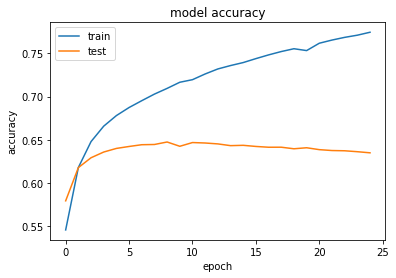

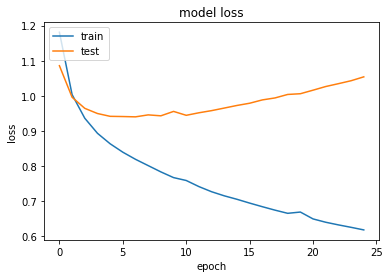

In [50]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
# inception_model = tf.keras.models.load_model('models/inception.h5')
inception_model.evaluate(test_ds)

32070/32070 [==============================] - 68s 2ms/step - loss: 1.1191 - accuracy: 0.6174


[1.1191132068634033, 0.6173994541168213]

In [52]:
preds = inception_model.predict(test_ds)

In [53]:
# Get aggregated predictions
y_pred = get_max_preds(preds)
accuracy_score(y_true, y_pred)

0.6814780168381666

In [54]:
print(classification_report(y_true, y_pred, digits=3, target_names=label_list, zero_division=0))

              precision    recall  f1-score   support

        NORM      0.744     0.929     0.826       921
          MI      0.564     0.532     0.548       406
        STTC      0.642     0.541     0.587       351
         HYP      0.431     0.423     0.427       111
          CD      0.744     0.424     0.540       349

    accuracy                          0.681      2138
   macro avg      0.625     0.570     0.586      2138
weighted avg      0.677     0.681     0.667      2138



optimize model for **precision** when you want to **decrease the number of false positives**.

optimize model for **recall** if you want to **decrease the number of false negatives**.

# Model 4: LSTM

In [55]:
learning_rate = 0.0001
dropout_rate = 0.25

lstm_model = keras.models.Sequential([
    
    keras.layers.LSTM(units=128, return_sequences=True, input_shape=input_shape),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=dropout_rate),
    
    keras.layers.LSTM(units=64, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=dropout_rate),
    
    keras.layers.LSTM(units=32, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=dropout_rate),
    
    keras.layers.Dense(128),
    keras.layers.Activation('relu'),
    
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dropout(rate=dropout_rate),
    
    keras.layers.Dense(num_classes, activation='softmax')
])


opt = keras.optimizers.Adam(learning_rate=learning_rate)

lstm_model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=opt)

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 128)           194048    
                                                                 
 batch_normalization_30 (Bat  (None, 12, 128)          512       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 12, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 64)            49408     
                                                                 
 batch_normalization_31 (Bat  (None, 12, 64)           256       
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 12, 64)           

In [56]:
epochs = 100
model_output = 'models/lstm.h5'

callbacks = [keras.callbacks.ModelCheckpoint(model_output, save_best_only=True, monitor="val_loss"),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),]

history = lstm_model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=epochs,
                         callbacks=callbacks,
                         verbose=1)

Epoch 1/100
868/868 [==============================] - 21s 20ms/step - loss: 1.4429 - accuracy: 0.4100 - val_loss: 1.3165 - val_accuracy: 0.4767
Epoch 2/100
868/868 [==============================] - 16s 18ms/step - loss: 1.3009 - accuracy: 0.4840 - val_loss: 1.2147 - val_accuracy: 0.5239
Epoch 3/100
868/868 [==============================] - 16s 18ms/step - loss: 1.2347 - accuracy: 0.5140 - val_loss: 1.1654 - val_accuracy: 0.5464
Epoch 4/100
868/868 [==============================] - 16s 18ms/step - loss: 1.1928 - accuracy: 0.5349 - val_loss: 1.1378 - val_accuracy: 0.5551
Epoch 5/100
868/868 [==============================] - 16s 18ms/step - loss: 1.1617 - accuracy: 0.5501 - val_loss: 1.1219 - val_accuracy: 0.5604
Epoch 6/100
868/868 [==============================] - 16s 18ms/step - loss: 1.1383 - accuracy: 0.5620 - val_loss: 1.1123 - val_accuracy: 0.5628
Epoch 7/100
868/868 [==============================] - 16s 18ms/step - loss: 1.1189 - accuracy: 0.5714 - val_loss: 1.1073 - val_ac

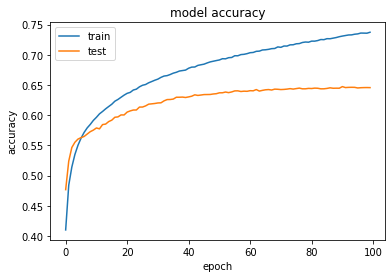

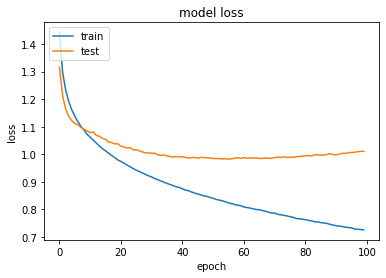

In [57]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [58]:
# lstm_model = tf.keras.models.load_model('models/lstm.h5')
lstm_model.evaluate(test_ds)

32070/32070 [==============================] - 92s 3ms/step - loss: 1.0602 - accuracy: 0.6354


[1.060244083404541, 0.635391354560852]

In [59]:
preds = lstm_model.predict(test_ds)

In [60]:
# Get aggregated predictions
y_pred = get_max_preds(preds)
accuracy_score(y_true, y_pred)

0.6856875584658559

In [61]:
# Get aggregated predictions
y_pred = get_max_preds(preds)
accuracy_score(y_true, y_pred)

0.6856875584658559

In [62]:
print(classification_report(y_true, y_pred, digits=3, target_names=label_list, zero_division=0))

              precision    recall  f1-score   support

        NORM      0.735     0.946     0.827       921
          MI      0.529     0.606     0.565       406
        STTC      0.727     0.501     0.594       351
         HYP      0.492     0.288     0.364       111
          CD      0.779     0.404     0.532       349

    accuracy                          0.686      2138
   macro avg      0.653     0.549     0.576      2138
weighted avg      0.689     0.686     0.667      2138



# Model 5: Ensemble

In [63]:
resnet_model = tf.keras.models.load_model('models/resnet.h5')
inception_model = tf.keras.models.load_model('models/inception.h5')
# lstm_model = tf.keras.models.load_model('models/lstm.h5')

In [64]:
models = [resnet_model, inception_model,lstm_model]
model_input = tf.keras.Input(shape=input_shape)
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

opt = keras.optimizers.Adam(learning_rate=learning_rate)

ensemble_model.compile(loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'],
                          optimizer=opt)

ensemble_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 12, 250)]    0           []                               
                                                                                                  
 model (Functional)             (None, 5)            650629      ['input_4[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 5)            106421      ['input_4[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 5)            261637      ['input_4[0][0]']                
                                                                                            

In [65]:
ensemble_model.evaluate(test_ds)

32070/32070 [==============================] - 186s 6ms/step - loss: 0.9092 - accuracy: 0.6567


[0.909203052520752, 0.6566885113716125]

In [66]:
preds = resnet_model.predict(test_ds)

In [67]:
# Get aggregated predictions
y_pred = get_max_preds(preds)
accuracy_score(y_true, y_pred)

0.6632366697848456

In [68]:
print(classification_report(y_true, y_pred, digits=3, target_names=label_list, zero_division=0))

              precision    recall  f1-score   support

        NORM      0.723     0.948     0.820       921
          MI      0.543     0.470     0.504       406
        STTC      0.613     0.487     0.543       351
         HYP      0.402     0.387     0.394       111
          CD      0.729     0.401     0.518       349

    accuracy                          0.663      2138
   macro avg      0.602     0.539     0.556      2138
weighted avg      0.655     0.663     0.643      2138

